In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculating Probabilities

In [2]:
def Probs(df_train, sm):
    class_probs = df_train.groupby('class').size().div(len(df_train))
    atr_pr = list()
    atr_pro = list()
    i=0
    for atr in column_names[:-1]:
        atr_pr.append(df_train.groupby(['class',atr]).size())
        levels = [atr_pr[i].index.levels[0].values, atr_pr[i].index.levels[1].values]
        new_index = pd.MultiIndex.from_product(levels)
        atr_pr[i] = atr_pr[i].reindex(new_index, fill_value=0)
        atr_pro.append((atr_pr[i]+sm).div(df_train.groupby('class').size()+(((pd.unique(df_train[atr].values)).size)*sm), axis=0, level=0))
        i+=1
    return atr_pro, class_probs

# Prediction

In [3]:
def predict(xs, ylist, atr_pro, class_probs):
    y = np.array(class_probs)
    for x in range(xs.size-1):
        #print(atr_pro[x]['good'][xs[x]])
        y[0] *= atr_pro[x][ylist[0]][xs[x]]
        y[1] *= atr_pro[x][ylist[1]][xs[x]]
        y[2] *= atr_pro[x][ylist[2]][xs[x]]
        y[3] *= atr_pro[x][ylist[3]][xs[x]]
    arg = np.argmax(y)
    a = ylist[arg]
    #print(a)
    #print(y)
    return y,a

In [4]:
def predictall(x_test, ylist, atr_pro, class_probs):
    y_pred, y_pred_all = list(), np.zeros((x_test.shape[0],4))
    for i in range(x_test.shape[0]):
        y_pred_all[i,:], y_p = predict(x_test.iloc[i], ylist, atr_pro, class_probs)
        y_pred.append(y_p)
    return y_pred_all, y_pred

# Computing Confusion Matrix and Rates

In [5]:
def ConfusionMatrix(y_pred, y_test, ylist):
    mat = np.zeros((4,4))
    print(y_test.size)
    for p in range(y_test.size):
        mat[ylist.index(y_test.iloc[p]),ylist.index(y_pred[p])] +=1
    return mat

In [6]:
def Compute(mat):
    tpr, tnr, fpr, fnr = np.zeros(4), np.zeros(4), np.zeros(4), np.zeros(4)
    for i in range(4):
        tpr[i] = mat[i,i]/np.sum(mat[i,:])
        fpr[i] = (np.sum(mat[:,i])-mat[i,i])/(np.sum(mat)-np.sum(mat[i,:]))
        tnr[i] = 1-fpr[i]
        fnr[i] = 1-tpr[i]
    mean_tpr = np.mean(tpr)
    mean_fpr = np.mean(fpr)
    mean_tnr = np.mean(tnr)
    mean_fnr = np.mean(fnr)
    return tpr,fpr,tnr,fnr,mean_tpr,mean_fpr,mean_tnr,mean_fnr

# ROC

In [7]:
def rocthresh(threshold,y_pred_all,y_test, ylist):
    tp, tn, fp, fn = np.zeros(4), np.zeros(4), np.zeros(4), np.zeros(4)
    tpr, fpr = np.zeros(4), np.zeros(4)
        
    for k in range(4):
        h=0
        for y in y_pred_all[:,k]:
            if y>=threshold:
                if y_test.iloc[h]==ylist[k]:
                    tp[k]+=1
                else:
                    fp[k]+=1
            else:
                if y_test.iloc[h]==ylist[k]:
                    fn[k]+=1
                else:
                    tn[k]+=1 
            h+=1
        tpr[k] = tp[k]/(tp[k]+fn[k])
        fpr[k] = fp[k]/(fp[k]+tn[k])
    return tpr,fpr

In [8]:
def ROC(thresholds,y_pred_all,y_test, ylist):
    tpr, fpr = np.zeros((thresholds.size,4)), np.zeros((thresholds.size,4))
    
    for t in range(thresholds.size):
        tpr[t,:], fpr[t,:] = rocthresh(thresholds[t],y_pred_all,y_test, ylist)
    return tpr,fpr


# Answers

In [9]:
def Classify(smoothing, df_train, df_test):
    if smoothing==False:
        sm=0
    else:
        sm=1
    
    atr_pro, class_probs = Probs(df_train, sm)
    ylist = list(atr_pro[0].index.levels[0].values)
    
    x_test = df_test.drop('class',axis=1)
    y_test = df_test['class']
    y_pred_all,y_pred = predictall(x_test, ylist, atr_pro, class_probs)
    mat = ConfusionMatrix(y_pred, y_test, ylist)
    tpr,fpr,tnr,fnr,mean_tpr,mean_fpr,mean_tnr,mean_fnr = Compute(mat)
    
    print(ylist)
    print(atr_pro)
    print(class_probs)
    print(mat)
    print('mean of tpr: ', mean_tpr)
    print('mean of fpr: ', mean_fpr)
    print('mean of tnr: ', mean_tnr)
    print('mean of fnr: ', mean_fnr)
    return y_pred_all, y_test, ylist

In [10]:
column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df = pd.read_csv('F://Uni/991/Machine_Learning/ML_HW3/car/car.data',names=column_names, header=None)
df = df.sample(frac=1 ,replace=False, axis = 0).reset_index(drop=True)
df_train = df.iloc[:int(0.7*df.shape[0])]
df_test = df.iloc[int(0.7*df.shape[0]):]

In [11]:
smoothing = False
y_pred_all_train_nosmooth, y_train_nosmooth, ylist_train_nosmooth = Classify(smoothing, df_train, df_train)

1209
['acc', 'good', 'unacc', 'vgood']
[acc    high     0.281139
       low      0.234875
       med      0.295374
       vhigh    0.188612
good   high     0.000000
       low      0.673469
       med      0.326531
       vhigh    0.000000
unacc  high     0.260504
       low      0.220888
       med      0.226891
       vhigh    0.291717
vgood  high     0.000000
       low      0.608696
       med      0.391304
       vhigh    0.000000
dtype: float64, acc    high     0.274021
       low      0.227758
       med      0.306050
       vhigh    0.192171
good   high     0.000000
       low      0.653061
       med      0.346939
       vhigh    0.000000
unacc  high     0.264106
       low      0.218487
       med      0.226891
       vhigh    0.290516
vgood  high     0.217391
       low      0.369565
       med      0.413043
       vhigh    0.000000
dtype: float64, acc    2        0.202847
       3        0.245552
       4        0.298932
       5more    0.252669
good   2        0.224490
   

In [12]:
smoothing = False
y_pred_all_test_nosmooth, y_test_nosmooth, ylist_test_nosmooth = Classify(smoothing, df_train, df_test)

519
['acc', 'good', 'unacc', 'vgood']
[acc    high     0.281139
       low      0.234875
       med      0.295374
       vhigh    0.188612
good   high     0.000000
       low      0.673469
       med      0.326531
       vhigh    0.000000
unacc  high     0.260504
       low      0.220888
       med      0.226891
       vhigh    0.291717
vgood  high     0.000000
       low      0.608696
       med      0.391304
       vhigh    0.000000
dtype: float64, acc    high     0.274021
       low      0.227758
       med      0.306050
       vhigh    0.192171
good   high     0.000000
       low      0.653061
       med      0.346939
       vhigh    0.000000
unacc  high     0.264106
       low      0.218487
       med      0.226891
       vhigh    0.290516
vgood  high     0.217391
       low      0.369565
       med      0.413043
       vhigh    0.000000
dtype: float64, acc    2        0.202847
       3        0.245552
       4        0.298932
       5more    0.252669
good   2        0.224490
    

In [13]:
smoothing = True
y_pred_all_train_smooth, y_train_smooth, ylist_train_smooth = Classify(smoothing, df_train, df_train)

1209
['acc', 'good', 'unacc', 'vgood']
[acc    high     0.280702
       low      0.235088
       med      0.294737
       vhigh    0.189474
good   high     0.018868
       low      0.641509
       med      0.320755
       vhigh    0.018868
unacc  high     0.260454
       low      0.221027
       med      0.227001
       vhigh    0.291517
vgood  high     0.020000
       low      0.580000
       med      0.380000
       vhigh    0.020000
dtype: float64, acc    high     0.273684
       low      0.228070
       med      0.305263
       vhigh    0.192982
good   high     0.018868
       low      0.622642
       med      0.339623
       vhigh    0.018868
unacc  high     0.264038
       low      0.218638
       med      0.227001
       vhigh    0.290323
vgood  high     0.220000
       low      0.360000
       med      0.400000
       vhigh    0.020000
dtype: float64, acc    2        0.203509
       3        0.245614
       4        0.298246
       5more    0.252632
good   2        0.226415
   

In [14]:
smoothing = True
y_pred_all_test_smooth, y_test_smooth, ylist_test_smooth = Classify(smoothing, df_train, df_test)

519
['acc', 'good', 'unacc', 'vgood']
[acc    high     0.280702
       low      0.235088
       med      0.294737
       vhigh    0.189474
good   high     0.018868
       low      0.641509
       med      0.320755
       vhigh    0.018868
unacc  high     0.260454
       low      0.221027
       med      0.227001
       vhigh    0.291517
vgood  high     0.020000
       low      0.580000
       med      0.380000
       vhigh    0.020000
dtype: float64, acc    high     0.273684
       low      0.228070
       med      0.305263
       vhigh    0.192982
good   high     0.018868
       low      0.622642
       med      0.339623
       vhigh    0.018868
unacc  high     0.264038
       low      0.218638
       med      0.227001
       vhigh    0.290323
vgood  high     0.220000
       low      0.360000
       med      0.400000
       vhigh    0.020000
dtype: float64, acc    2        0.203509
       3        0.245614
       4        0.298246
       5more    0.252632
good   2        0.226415
    

In [15]:
def plotROC(thresholds,y_pred_all,y_test, ylist):
    tpr, fpr = ROC(thresholds,y_pred_all,y_test, ylist)
    for f in range(4):
        plt.plot(fpr[:,f],tpr[:,f],label= ylist[f])
    plt.legend()
    plt.show()

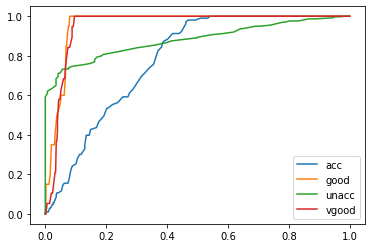

In [18]:
thresholds = np.arange(0,0.004,0.00001)
plotROC(thresholds,y_pred_all_test_nosmooth, y_test_nosmooth, ylist_test_nosmooth)

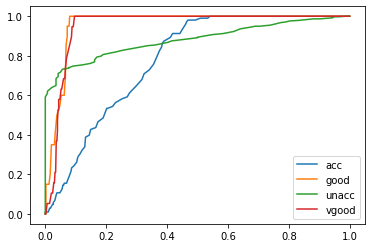

In [19]:
#thresholds = np.arange(0,0.003,0.00001)
#plotROC(thresholds,y_pred_all_test_smooth, y_test_smooth, ylist_test_smooth)